In [5]:
import os, time, sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms,datasets
from matplotlib import pyplot as plt
from tqdm import tqdm
# from summary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dsets_paths = "./data/imgs_Face"
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    
])
dsets = datasets.ImageFolder(dsets_paths, transform)
dlsets = DataLoader(dsets, batch_size=512, shuffle = True, num_workers=4)

class torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, bias=True)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.g = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, 4, 1, 0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        y = self.g(x)
        return y
    
# G = Generator()
# print(G)
# summary(G,input_shape=(100,1,1))

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.d = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, 4),
            nn.Sigmoid()
        )
        
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        y = self.d(x)
        return y
    
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()
        
# D = Discriminator()
# print(D)
# summary(D,input_shape=(3,64,64))

In [9]:
def show_result(size_figure_grid=3, path='result.png'):
    z = torch.randn((size_figure_grid**2, 100, 1, 1), device=device)

    G.eval()
    test_images = G(z)
    G.train()
    
    plt.figure(figsize=(size_figure_grid,size_figure_grid)) 
    for i in range(size_figure_grid**2):
        img = test_images[i]
        ax=plt.subplot(size_figure_grid,size_figure_grid,i+1)
        ax.imshow((img.cpu().data.permute(1,2,0).numpy() + 1) / 2)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()
    plt.savefig(path)


In [10]:
def show_train_hist(hist, path='Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(path)
    plt.show()

In [16]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

# training parameters
lr = 0.0002
train_epoch = 100
k = 1
# network
G = Generator()
D = Discriminator()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
#G.load_state_dict(torch.load('./generator_f.pkl'))
#D.load_state_dict(torch.load('./discriminator_f.pkl'))
G.to(device)
D.to(device)
G.train()
D.train()
# Binary Cross Entropy loss
BCE_loss = nn.BCELoss().to(device)
# Adam optimizer
G_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
print('Training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []

    # learning rate decay
    # if (epoch + 1) == 11:
    #    G_optimizer.param_groups[0]['lr'] /= 10
    #    D_optimizer.param_groups[0]['lr'] /= 10
    #    print("learning rate change!")

    #if (epoch + 1) == 21:
    #    G_optimizer.param_groups[0]['lr'] /= 10
    #    D_optimizer.param_groups[0]['lr'] /= 10
    #    print("learning rate change!")

    epoch_start_time = time.time()
    for batch_idx, (x, _) in tqdm(enumerate(dlsets), total =len(dlsets)):
        # train discriminator D
        D.zero_grad()
        mini_batch = x.size()[0]
        
        y_real = torch.ones(mini_batch, device=device)
        y_fake = torch.zeros(mini_batch, device=device)
        x = x.to(device)

        D_result = D(x).squeeze()
        D_real_loss = BCE_loss(D_result, y_real)

        z = torch.randn((mini_batch, 100, 1, 1), device = device)
        G_result = G(z)

        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()
        
        z = torch.randn((mini_batch, 100, 1, 1), device = device)
        G_result = G(z)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real)  # 训练初期用log(D(G(z)))
        # G_train_loss = -BCE_loss(D_result, y_fake)  # 训练后期
        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % (
    (epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
    torch.mean(torch.FloatTensor(G_losses))))
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)).item())
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)).item())
    show_result(3)
    torch.save(G.state_dict(), './generator_f1.pkl')
    torch.save(D.state_dict(), './discriminator_f1.pkl')

show_train_hist(train_hist)

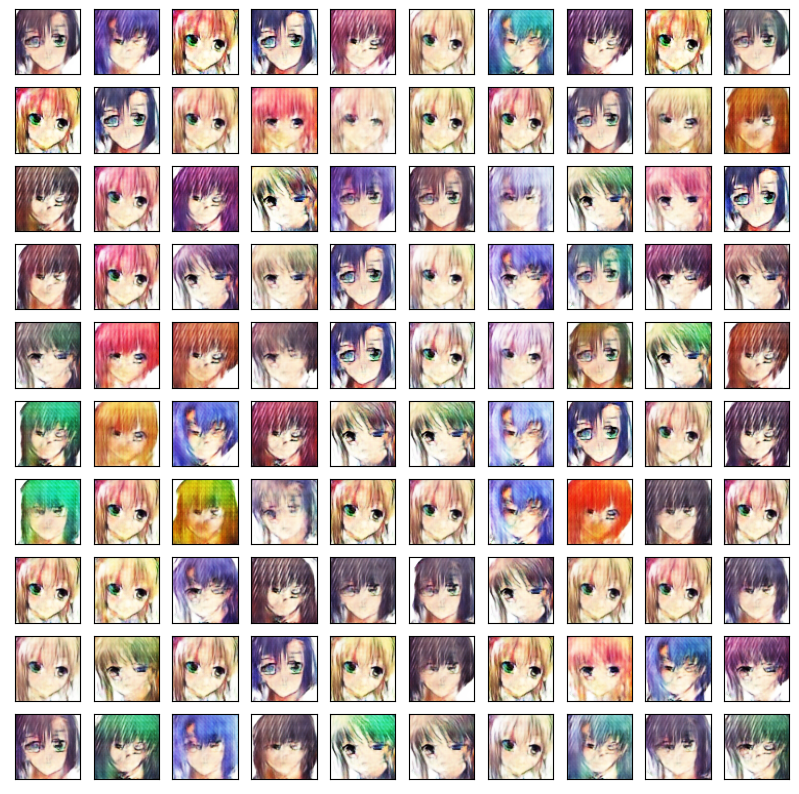

<Figure size 640x480 with 0 Axes>

In [20]:
show_result(10)